In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
plt.rcParams['font.family'] = 'serif'

import emcee
import corner
from scipy.optimize import minimize
from IPython.display import Math

import model_transits

In [2]:
data_arr = np.load('/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/arrays/data_arr.npy', allow_pickle=True)

dates = ['2022-04-01', '2022-06-02', '2023-07-31', '2023-08-14', '2024-05-13', 
         '2024-06-06', '2024-06-13', '2024-06-23', '2024-06-30', '2024-07-07',
         '2024-07-14', '2024-07-24', '2024-08-07', '2024-08-14', '2025-05-17',
         '2025-05-24', '2025-06-07', '2025-06-17', '2025-07-01', '2025-07-18']
base_dir = '/Users/eligendreaudistler/Desktop/wd-1856-534b/arrays'

for i, date in enumerate(dates):
    theta_mcmc = np.load('../arrays/theta_mcmc_{}.npy'.format(date))
    data_arr[i]['BJD_TDB'] -= theta_mcmc[0] # center midtransit on time 0

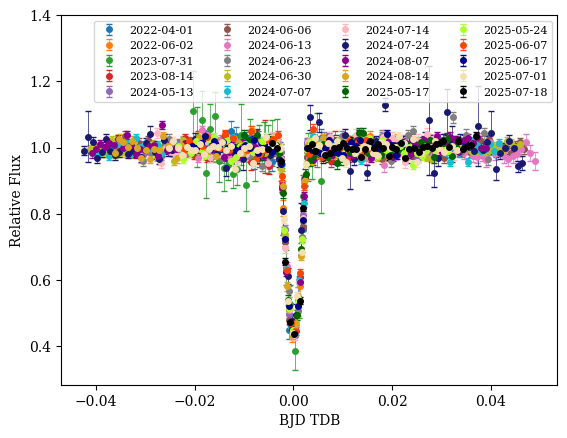

In [6]:
# plot raw data
%matplotlib inline

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',
          'lightpink', 'midnightblue', 'darkmagenta', 'goldenrod', 
          'darkgreen', 'greenyellow', 'orangered', 'darkblue', 'wheat', 'black']

for i, color in enumerate(colors):
    plt.errorbar(data_arr[i]['BJD_TDB'], data_arr[i]['rel_flux_T1_normalized'], linestyle='none', marker='o', 
                markersize=4, yerr=data_arr[i]['rel_flux_err_T1_normalized'], elinewidth=0.5, capsize=2, color=color, label=dates[i])
plt.xlabel("BJD TDB")
plt.ylabel("Relative Flux")
plt.ylim(top=1.4)

plt.legend(loc='upper right', ncol=4, fontsize=8);

In [7]:
bjd_tdb = []
rel_flux = []
rel_flux_err = []

for i in range(len(dates)):
    bjd_tdb.extend(data_arr[i]['BJD_TDB'].to_numpy())
    rel_flux.extend(data_arr[i]['rel_flux_T1_normalized'].to_numpy())
    rel_flux_err.extend(data_arr[i]['rel_flux_err_T1_normalized'].to_numpy())

bjd_tdb = np.array(bjd_tdb)
rel_flux = np.array(rel_flux)
rel_flux_err = np.array(rel_flux_err)

indices = np.argsort(bjd_tdb)
bjd_tdb = bjd_tdb[indices]
rel_flux = rel_flux[indices]
rel_flux_err = rel_flux_err[indices]

In [8]:
df = pd.DataFrame({
    'BJD_TDB': bjd_tdb,
    'rel_flux': rel_flux,
    'rel_flux_err': rel_flux_err
})

#df.to_excel('combined_lightcurves.xlsx', index=False)

In [9]:
#df = pd.read_excel('combined_lightcurves.xlsx')

bjd_tdb = df['BJD_TDB'].values
rel_flux = df['rel_flux'].values
rel_flux_err = df['rel_flux_err'].values

In [10]:
mask = np.abs(bjd_tdb) < 0.005
bjd_tdb = bjd_tdb[mask]
rel_flux = rel_flux[mask]
rel_flux_err = rel_flux_err[mask]

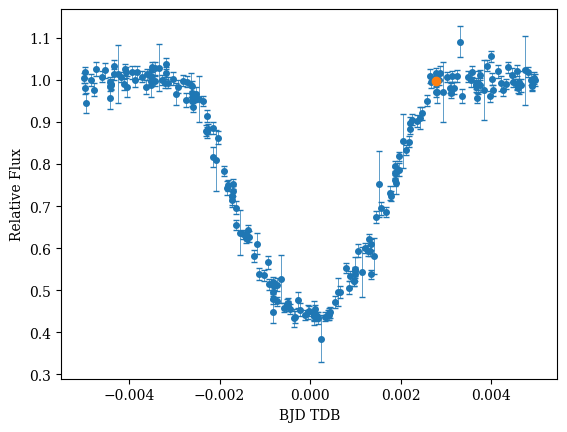

In [20]:
# plot raw data
%matplotlib inline

i = 165
plt.errorbar(bjd_tdb, rel_flux, linestyle='none', marker='o', 
             markersize=4, yerr=rel_flux_err, elinewidth=0.5, capsize=2)
plt.plot(bjd_tdb[i], rel_flux[i], 'o', markersize=6, zorder=3)
plt.xlabel("BJD TDB")
plt.ylabel("Relative Flux");

In [21]:
# number of first and last normal data points before/after transit
# and data point closest to midpoint of transit
start = 46
mid = 107
end = 165

In [22]:
median = np.median(np.concatenate((rel_flux[:start], rel_flux[end:])))
rel_flux_normalized = rel_flux / median
rel_flux_err_normalized = rel_flux_err / median

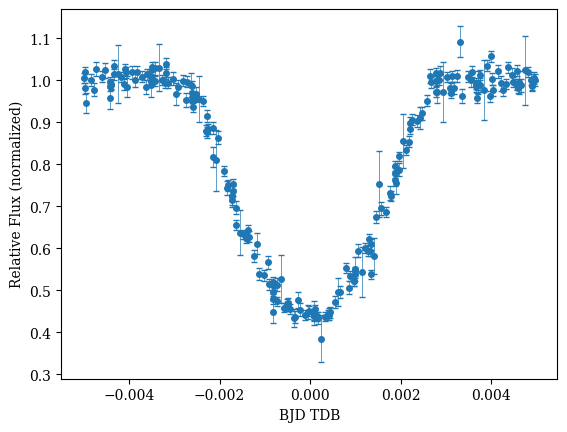

In [23]:
# plot normalized data
%matplotlib inline
plt.errorbar(bjd_tdb, rel_flux_normalized, linestyle='none', linewidth=1.5, marker='o', 
             markersize=4, yerr=rel_flux_err_normalized, elinewidth=0.5, capsize=2)
plt.xlabel("BJD TDB")
plt.ylabel("Relative Flux (normalized)");

In [30]:
period = 1.4079405
times = np.arange(bjd_tdb[0], bjd_tdb[-1], 0.00001)
theta_mcmc = [0, 8.3, 0.00294, 8.4, 0.52, 0.52, 1]

In [31]:
t0, b, r_a, Rp_Rs, log_f, u1, u2 = theta_mcmc
detrend = rel_flux_normalized
model = model_transits.modeltransit([t0, b, r_a, Rp_Rs, 1, u1, u2], model_transits.occultquad, period, bjd_tdb);
res = detrend - model

/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/fit_lightcurves/model_transits.py:852: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


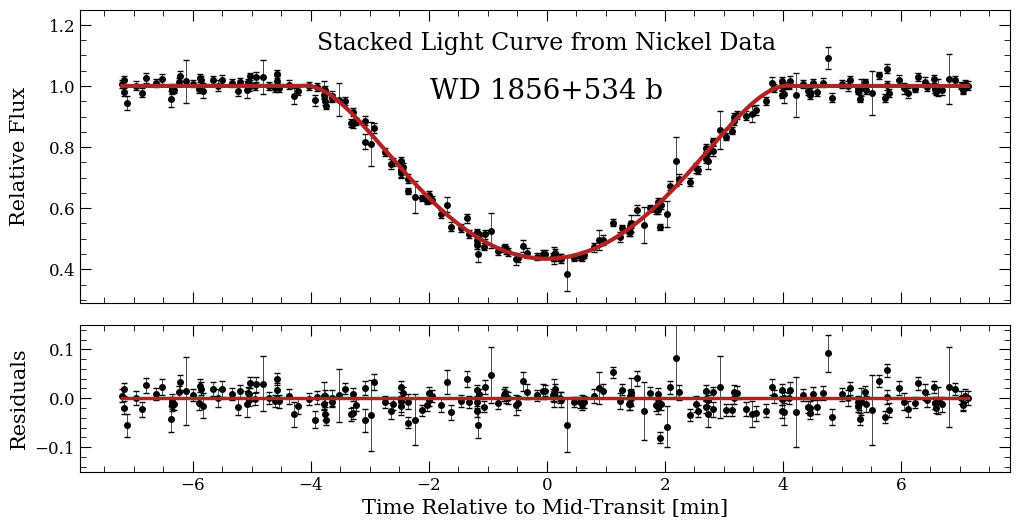

In [32]:
model_times = model_transits.modeltransit([t0, b, r_a, Rp_Rs, 1, u1, u2], model_transits.occultquad, period, times)

fig, ax = plt.subplots(2, sharex=True, figsize=(12, 6), gridspec_kw={'height_ratios': [2, 1]})
plt.rcParams['font.family'] = 'serif'
plt.subplots_adjust(hspace=0.1)

for a in ax:
    a.minorticks_on()
    a.tick_params(axis='both', labelsize=12)
    a.tick_params(direction='in', which='minor', length=4, bottom=True, top=True, left=True, right=True)
    a.tick_params(direction='in', which='major', length=8, bottom=True, top=True, left=True, right=True)

ax[0].errorbar(bjd_tdb*24*60, detrend, yerr=rel_flux_err, linestyle='', linewidth=1.5, marker='o', 
               markersize=4, elinewidth=0.5, capsize=2, color='black')
ax[0].plot(times*24*60, model_times, color='firebrick', linewidth=3, zorder=3)

ax[1].errorbar(bjd_tdb*24*60, res, yerr=rel_flux_err, linestyle='', linewidth=1.5, marker='o', 
               markersize=4, elinewidth=0.5, capsize=2, color='black', zorder=1)
ax[1].plot([bjd_tdb[0]*24*60, bjd_tdb[-1]*24*60], [0, 0], color='firebrick', linewidth=2.5, zorder=2)

plt.xlabel(r"Time Relative to Mid-Transit [min]", fontsize=15)
ax[0].set_ylabel("Relative Flux", fontsize=15)
ax[1].set_ylabel("Residuals", fontsize=15)
ax[1].set_ylim(-0.15, 0.15)
fig.align_ylabels()

ax[0].set_ylim(bottom=None, top=1.25)
ax[0].text(0, 1.12, 'Stacked Light Curve from Nickel Data', horizontalalignment='center', fontsize=17)
ax[0].text(0, 0.96, 'WD 1856+534 b', horizontalalignment='center', fontsize=20)

savepath = '/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/imgs/stacked_lightcurve.pdf'
plt.savefig(savepath, format='pdf', bbox_inches='tight');